### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (2 балл)

4) Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями (1 балл)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable, grad

In [ ]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 32
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 100
config.print_freq = 500
config.n_critic = 3
config.clip_value = 0.01
config.lambda_gp = 10
config.num_classes = 10

In [ ]:
train = torchvision.datasets.FashionMNIST(
    "fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [ ]:
dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True)

In [ ]:
len(dataloader)

1875

In [ ]:
for image, cat in dataloader:
    break

In [ ]:
image.size()

torch.Size([32, 1, 28, 28])

In [ ]:
28*28

784

## Задание 1. Wasserstein GAN with weight clipping

In [ ]:
class GeneratorWGAN(nn.Module):
    def __init__(self):
        super(GeneratorWGAN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class DiscriminatorWGAN(nn.Module):
    def __init__(self):
        super(DiscriminatorWGAN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
def train_wgan_clip(generator=GeneratorWGAN(), discriminator=DiscriminatorWGAN()):
    optim_G = optim.RMSprop(generator.parameters(), lr=0.00005)
    optim_D = optim.RMSprop(discriminator.parameters(), lr=0.00005)

    losses_G = []
    losses_D = []

    for epoch in range(config.num_epochs):
        for iteration, (images, cat) in enumerate(dataloader):
            batch_size = image.size(0)
            real_imgs = images.view(batch_size, -1)*2 - 1 # нормализация в -1 1

            for _ in range(config.n_critic):

                optim_D.zero_grad()

                real_validity = discriminator(real_imgs)

                noise = torch.randn(batch_size, config.noise_size)
                fake_imgs = generator(noise)
                fake_validity = discriminator(fake_imgs.detach())

                # W - Loss
                loss_D = -torch.mean(real_validity) + torch.mean(fake_validity)
                loss_D.backward()
                optim_D.step()

                for p in discriminator.parameters():
                    p.data.clamp_(-config.clip_value, config.clip_value)

            optim_G.zero_grad()

            noise = torch.randn(batch_size, config.noise_size)
            fake_imgs = generator(noise)
            fake_validity = discriminator(fake_imgs)

            loss_G = -torch.mean(fake_validity)
            loss_G.backward()
            optim_G.step()

            if iteration % config.print_freq == 0:
                print(f'Epoch [{epoch+1}/{config.num_epochs}] Iter [{iteration}/{len(dataloader)}] '
                      f'Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}')

            losses_G.append(loss_G)
            losses_D.append(loss_D)

    return generator, discriminator, losses_G, losses_D

Epoch [1/10] Iter [0/1875] Loss_D: -0.0031 Loss_G: -0.0094
Epoch [1/10] Iter [500/1875] Loss_D: -0.1069 Loss_G: -0.6558
Epoch [1/10] Iter [1000/1875] Loss_D: -0.1886 Loss_G: -0.2351
Epoch [1/10] Iter [1500/1875] Loss_D: -0.1526 Loss_G: -0.1641
Epoch [2/10] Iter [0/1875] Loss_D: -0.2277 Loss_G: 0.0987
Epoch [2/10] Iter [500/1875] Loss_D: -0.1654 Loss_G: -0.2320
Epoch [2/10] Iter [1000/1875] Loss_D: -0.0730 Loss_G: -0.3070
Epoch [2/10] Iter [1500/1875] Loss_D: -0.1375 Loss_G: -0.1049
Epoch [3/10] Iter [0/1875] Loss_D: -0.1409 Loss_G: -0.0001
Epoch [3/10] Iter [500/1875] Loss_D: -0.1203 Loss_G: -0.1514
Epoch [3/10] Iter [1000/1875] Loss_D: -0.1002 Loss_G: -0.2022
Epoch [3/10] Iter [1500/1875] Loss_D: -0.1162 Loss_G: -0.0343
Epoch [4/10] Iter [0/1875] Loss_D: -0.0640 Loss_G: -0.0650
Epoch [4/10] Iter [500/1875] Loss_D: -0.0940 Loss_G: -0.1486
Epoch [4/10] Iter [1000/1875] Loss_D: -0.1032 Loss_G: 0.0429
Epoch [4/10] Iter [1500/1875] Loss_D: -0.0791 Loss_G: -0.0526
Epoch [5/10] Iter [0/1875]

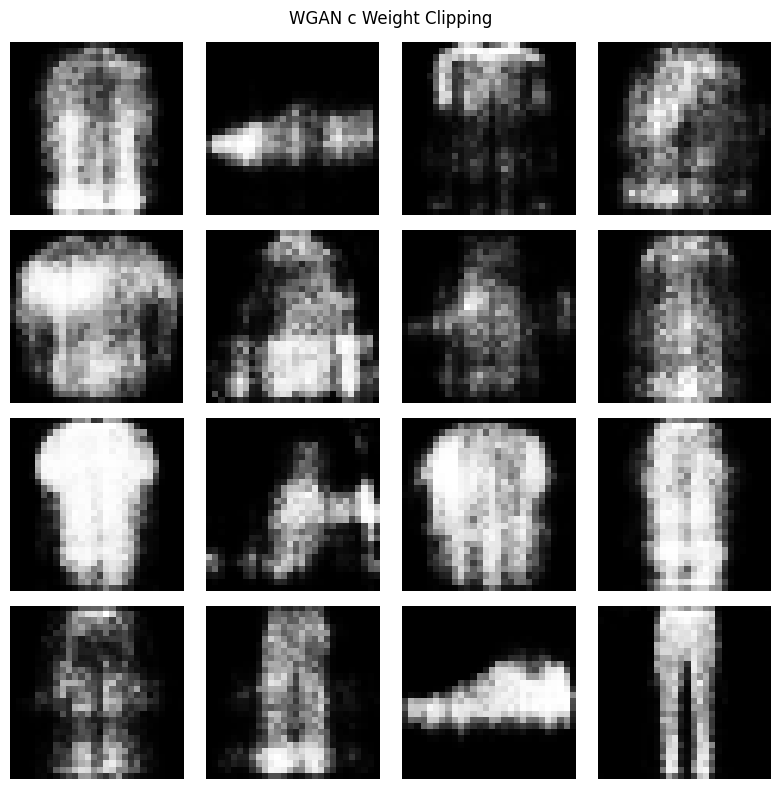

In [ ]:
gen_clip, dis_clip, losses_G_clip, losses_D_clip = train_wgan_clip(
    generator=GeneratorWGAN(),
    discriminator=DiscriminatorWGAN()
    )

noise = torch.randn(16, config.noise_size)
fake_imgs = gen_clip(noise)
fake_imgs = (fake_imgs + 1) / 2  # Денормализация

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake_imgs[i].detach().numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('WGAN с Weight Clipping')
plt.tight_layout()
plt.show()

 #### Сделали достаточно резкое увеличение размерности, давайте добавим слоев и посмотрим опять на результат + batchNorm (с batchNorm очень долго учится, убрал) Не хватает памяти для обучения, убрал этот кусок

In [ ]:
class GeneratorWGAN_large(nn.Module):
    def __init__(self):
        super(GeneratorWGAN_large, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class DiscriminatorWGAN_large(nn.Module):
    def __init__(self):
        super(DiscriminatorWGAN_large, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# gen_clip, dis_clip, losses_G_clip, losses_D_clip = train_wgan_clip(
#     generator=GeneratorWGAN_large(),
#     discriminator=DiscriminatorWGAN_large()
#     )

# noise = torch.randn(16, config.noise_size)
# fake_imgs = gen_clip(noise)
# fake_imgs = (fake_imgs + 1) / 2  # Денормализация

# plt.figure(figsize=(8, 8))
# for i in range(16):
#     plt.subplot(4, 4, i + 1)
#     plt.imshow(fake_imgs[i].detach().numpy().reshape(28, 28), cmap='gray')
#     plt.axis('off')
# plt.suptitle('WGAN с Weight Clipping')
# plt.tight_layout()
# plt.show()

## Задание 2. Wasserstein GAN with gradient penalty

In [ ]:
def gradient_penalty(discriminator, real, fake):
    batch_size = real.size(0)
    alpha = torch.rand(batch_size, 1)

    interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    d_interpolates = discriminator(interpolates)

    #gradient
    grad_out = torch.ones(batch_size, 1)
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_out,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) -1) **2).mean()
    return gradient_penalty

In [ ]:
def train_wgan_gp(generator=GeneratorWGAN(), discriminator=DiscriminatorWGAN()):

    optim_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.9))
    optim_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.9))

    losses_D = []
    losses_G = []
    gp_values = []

    for epoch in range(config.num_epochs):
        for iteration, (images, _) in enumerate(dataloader):
            batch_size = images.size(0)
            real_imgs = images.view(batch_size, -1) * 2 - 1

            for _ in range(config.n_critic):
                optim_D.zero_grad()

                noise = torch.randn(batch_size, config.noise_size)
                fake_imgs = generator(noise)

                real_validity = discriminator(real_imgs)
                fake_validity = discriminator(fake_imgs.detach())

                gp = gradient_penalty(discriminator, real_imgs, fake_imgs)

                loss_D = -torch.mean(real_validity) + torch.mean(fake_validity) + config.lambda_gp * gp
                loss_D.backward()
                optim_D.step()

            optim_G.zero_grad()

            noise = torch.randn(batch_size, config.noise_size)
            fake_imgs = generator(noise)
            fake_validity = discriminator(fake_imgs)

            loss_G = -torch.mean(fake_validity)
            loss_G.backward()
            optim_G.step()

            if iteration % config.print_freq == 0:
                print(f'Epoch [{epoch+1}/{config.num_epochs}] Iter [{iteration}/{len(dataloader)}] '
                      f'Loss_C: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f} GP: {gp.item():.4f}')

            losses_D.append(loss_D.item())
            losses_G.append(loss_G.item())
            gp_values.append(gp.item())

    return generator, discriminator, losses_G, losses_D, gp_values

Epoch [1/10] Iter [0/1875] Loss_C: 7.9751 Loss_G: -0.0982 GP: 0.8102
Epoch [1/10] Iter [500/1875] Loss_C: -8.7658 Loss_G: -4.6840 GP: 0.1425
Epoch [1/10] Iter [1000/1875] Loss_C: -5.0434 Loss_G: -7.3694 GP: 0.0641
Epoch [1/10] Iter [1500/1875] Loss_C: -3.7731 Loss_G: -5.7095 GP: 0.0431
Epoch [2/10] Iter [0/1875] Loss_C: -3.0954 Loss_G: -4.7424 GP: 0.0279
Epoch [2/10] Iter [500/1875] Loss_C: -3.8612 Loss_G: -2.4906 GP: 0.0347
Epoch [2/10] Iter [1000/1875] Loss_C: -3.9924 Loss_G: -1.5854 GP: 0.0434
Epoch [2/10] Iter [1500/1875] Loss_C: -4.7889 Loss_G: -0.6631 GP: 0.0471
Epoch [3/10] Iter [0/1875] Loss_C: -4.3956 Loss_G: -1.4290 GP: 0.0760
Epoch [3/10] Iter [500/1875] Loss_C: -4.7061 Loss_G: 0.5962 GP: 0.0490
Epoch [3/10] Iter [1000/1875] Loss_C: -5.3751 Loss_G: -0.7799 GP: 0.0458
Epoch [3/10] Iter [1500/1875] Loss_C: -3.6340 Loss_G: -1.5343 GP: 0.0487
Epoch [4/10] Iter [0/1875] Loss_C: -5.0375 Loss_G: -1.3461 GP: 0.0532
Epoch [4/10] Iter [500/1875] Loss_C: -4.1406 Loss_G: 0.0513 GP: 0.05

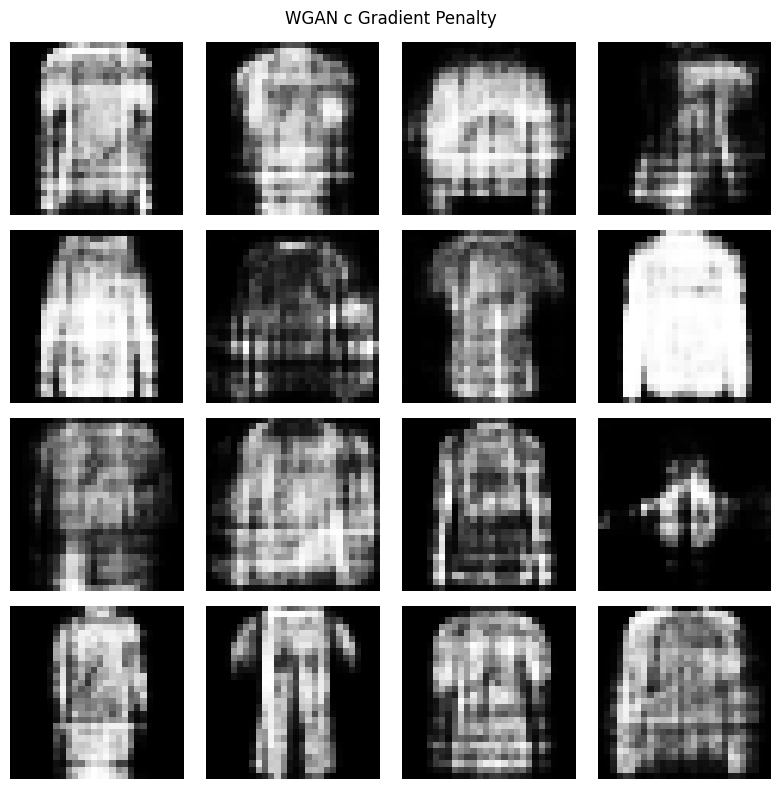

In [ ]:
gen_gp, critic_gp, losses_G_gp, losses_D_gp, gp_values = train_wgan_gp(
    generator=GeneratorWGAN(),
    discriminator=DiscriminatorWGAN()
    )

# Визуализация результатов
noise = torch.randn(16, config.noise_size)
fake_imgs = gen_gp(noise)
fake_imgs = (fake_imgs + 1) / 2

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake_imgs[i].detach().numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('WGAN с Gradient Penalty')
plt.tight_layout()
plt.show()

## Задание 3. Wasserstein GAN with Conditional

In [ ]:
class ConditionalGenerator(nn.Module):
    def __init__(self):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(config.num_classes, config.num_classes)
        self.model = nn.Sequential(
            nn.Linear(config.noise_size+config.num_classes, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 28*28),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat([noise, label_input], dim=1)
        return self.model(gen_input)

class ConditionalDiscriminator(nn.Module):
    def __init__(self):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(config.num_classes, config.num_classes)
        self.model = nn.Sequential(
            nn.Linear(28*28++ config.num_classes, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1)
        )

    def forward(self, img, labels):
        label_input = self.label_emb(labels)
        d_input = torch.cat([img, label_input], dim=1)
        return self.model(d_input)

In [ ]:
def gradient_penalty_conditional(discriminator, real, fake, labels):
    batch_size = real.size(0)
    alpha = torch.rand(batch_size, 1)

    interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    d_interpolates = discriminator(interpolates, labels)

    #gradient
    grad_out = torch.ones(batch_size, 1)
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_out,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) -1) **2).mean()
    return gradient_penalty

In [ ]:
def train_conditional_wgan(generator=GeneratorWGAN(), discriminator=DiscriminatorWGAN()):

    optim_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.9))
    optim_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.9))

    losses_D = []
    losses_G = []

    for epoch in range(config.num_epochs):
        for iteration, (images, labels) in enumerate(dataloader):
            batch_size = images.size(0)
            real_imgs = images.view(batch_size, -1) * 2 - 1

            for _ in range(config.n_critic):
                optim_D.zero_grad()

                noise = torch.randn(batch_size, config.noise_size)
                fake_imgs = generator(noise,labels)

                real_validity = discriminator(real_imgs,labels)
                fake_validity = discriminator(fake_imgs.detach(),labels)

                gp = gradient_penalty_conditional(discriminator, real_imgs, fake_imgs,labels)

                loss_D = -torch.mean(real_validity) + torch.mean(fake_validity) + config.lambda_gp * gp
                loss_D.backward()
                optim_D.step()

            optim_G.zero_grad()

            noise = torch.randn(batch_size, config.noise_size)
            fake_imgs = generator(noise,labels)
            fake_validity = discriminator(fake_imgs,labels)

            loss_G = -torch.mean(fake_validity)
            loss_G.backward()
            optim_G.step()

            if iteration % config.print_freq == 0:
                print(f'Epoch [{epoch+1}/{config.num_epochs}] Iter [{iteration}/{len(dataloader)}] '
                      f'Loss_C: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f} GP: {gp.item():.4f}')

            losses_D.append(loss_D.item())
            losses_G.append(loss_G.item())
            gp_values.append(gp.item())

    return generator, discriminator, losses_G, losses_D

In [ ]:
gen_cond, critic_cond, losses_G_cond, losses_D_cond = train_conditional_wgan(
    generator=ConditionalGenerator(),
    discriminator=ConditionalDiscriminator()
    )



Epoch [1/10] Iter [0/1875] Loss_C: 8.0441 Loss_G: -0.0052 GP: 0.8207
Epoch [1/10] Iter [500/1875] Loss_C: -9.2991 Loss_G: -4.1172 GP: 0.1737
Epoch [1/10] Iter [1000/1875] Loss_C: -6.7859 Loss_G: -5.9267 GP: 0.1189
Epoch [1/10] Iter [1500/1875] Loss_C: -7.0188 Loss_G: -9.5705 GP: 0.0843
Epoch [2/10] Iter [0/1875] Loss_C: -9.1625 Loss_G: -7.9246 GP: 0.1367
Epoch [2/10] Iter [500/1875] Loss_C: -7.7359 Loss_G: -11.2574 GP: 0.1087
Epoch [2/10] Iter [1000/1875] Loss_C: -7.2642 Loss_G: -16.3528 GP: 0.1116
Epoch [2/10] Iter [1500/1875] Loss_C: -6.3218 Loss_G: -14.7926 GP: 0.0750
Epoch [3/10] Iter [0/1875] Loss_C: -5.2829 Loss_G: -9.0187 GP: 0.0675
Epoch [3/10] Iter [500/1875] Loss_C: -4.0635 Loss_G: -7.3091 GP: 0.0675
Epoch [3/10] Iter [1000/1875] Loss_C: -3.7467 Loss_G: -7.3743 GP: 0.0285
Epoch [3/10] Iter [1500/1875] Loss_C: -3.4013 Loss_G: -5.5196 GP: 0.0365
Epoch [4/10] Iter [0/1875] Loss_C: -3.6205 Loss_G: -6.5959 GP: 0.0314
Epoch [4/10] Iter [500/1875] Loss_C: -2.8812 Loss_G: -4.4007 GP:

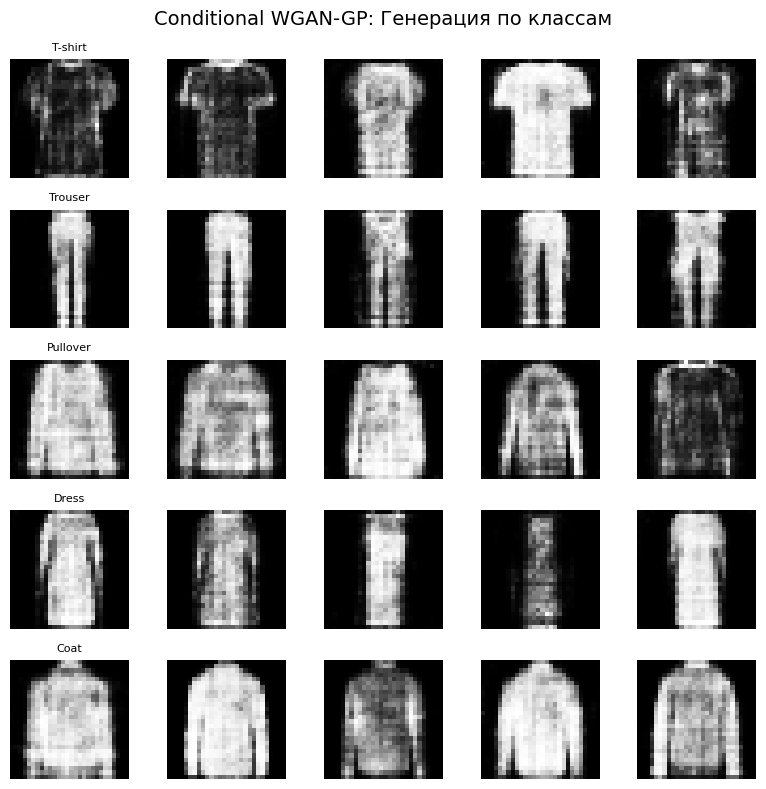

In [104]:
# Визуализация результатов
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(8, 8))
for class_idx in range(5):
    noise = torch.randn(5, config.noise_size)
    labels = torch.LongTensor([class_idx] * 5)
    fake_imgs = gen_cond(noise, labels)
    fake_imgs = (fake_imgs + 1) / 2

    for i in range(5):
        plt.subplot(5, 5, class_idx * 5 + i + 1)
        plt.imshow(fake_imgs[i].detach().numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(class_names[class_idx], fontsize=8)

plt.suptitle('Conditional WGAN-GP: Генерация по классам', fontsize=14)
plt.tight_layout()
plt.show()

### Задание 4 Сравнение результатов

In [106]:
# Конвертируем списки тензоров в списки чисел
if torch.is_tensor(losses_D_clip[0]):
    losses_D_clip = [loss.item() for loss in losses_D_clip]
    losses_G_clip = [loss.item() for loss in losses_G_clip]
    # losses_D_cond = [loss.item() for loss in losses_D_cond]
    losses_G_cond = [loss.item() for loss in losses_G_cond]

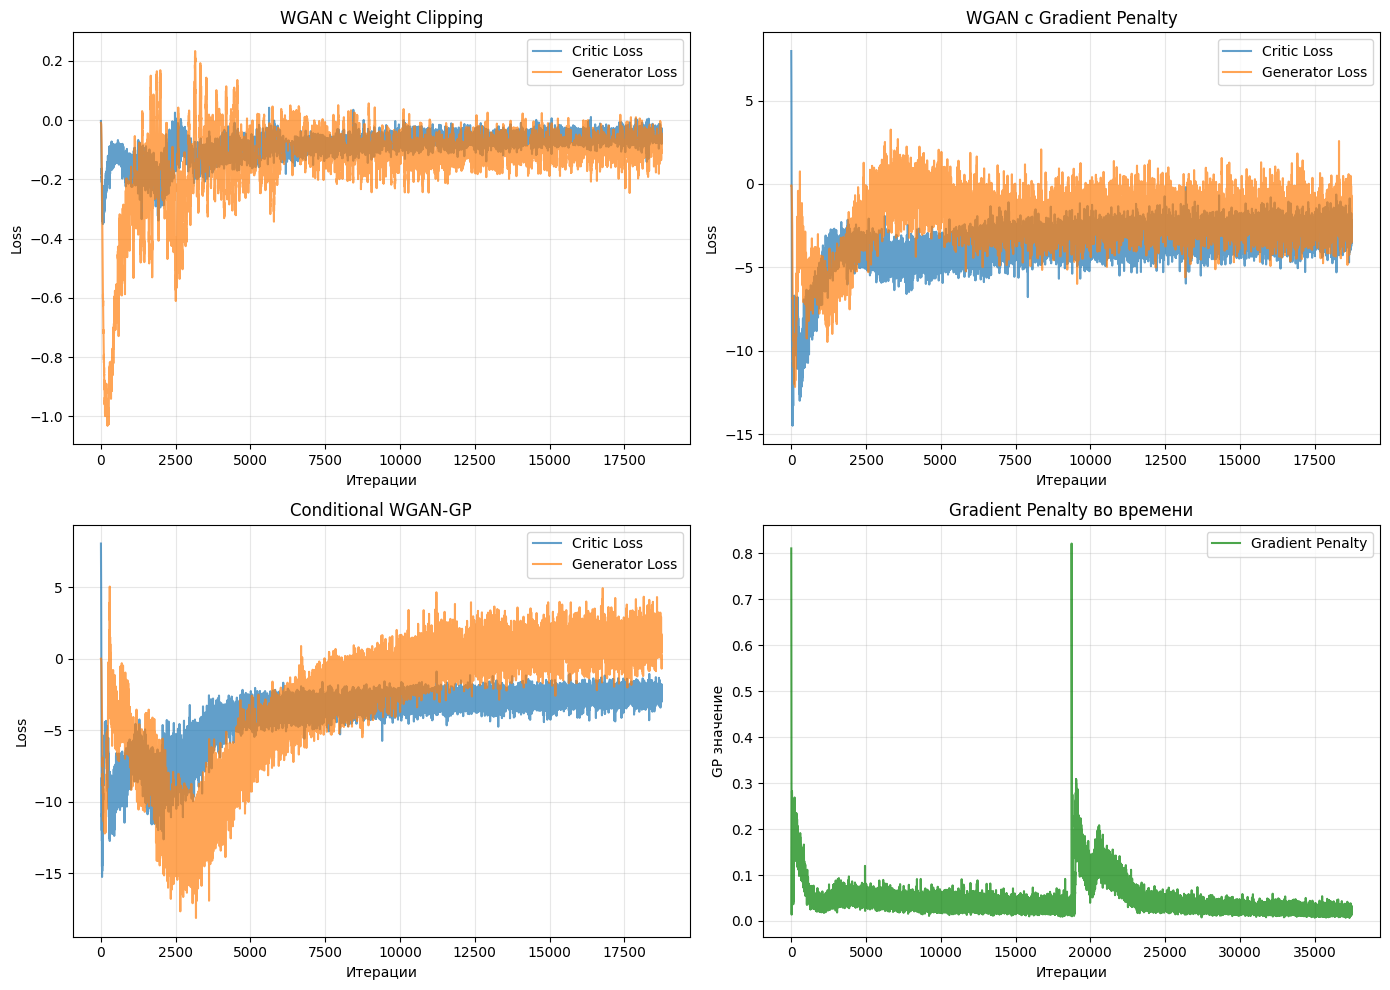

In [107]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(losses_D_clip, label='Critic Loss', alpha=0.7)
axes[0, 0].plot(losses_G_clip, label='Generator Loss', alpha=0.7)
axes[0, 0].set_title('WGAN с Weight Clipping')
axes[0, 0].set_xlabel('Итерации')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(losses_D_gp, label='Critic Loss', alpha=0.7)
axes[0, 1].plot(losses_G_gp, label='Generator Loss', alpha=0.7)
axes[0, 1].set_title('WGAN с Gradient Penalty')
axes[0, 1].set_xlabel('Итерации')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(losses_D_cond, label='Critic Loss', alpha=0.7)
axes[1, 0].plot(losses_G_cond, label='Generator Loss', alpha=0.7)
axes[1, 0].set_title('Conditional WGAN-GP')
axes[1, 0].set_xlabel('Итерации')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(gp_values, label='Gradient Penalty', alpha=0.7, color='green')
axes[1, 1].set_title('Gradient Penalty во времени')
axes[1, 1].set_xlabel('Итерации')
axes[1, 1].set_ylabel('GP значение')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



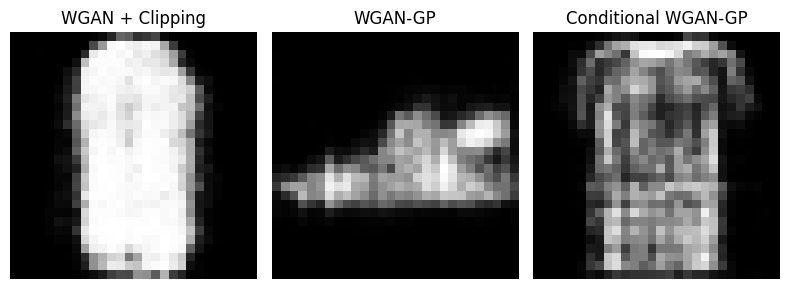

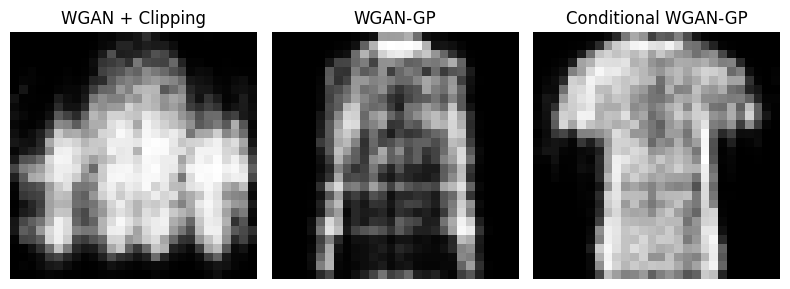

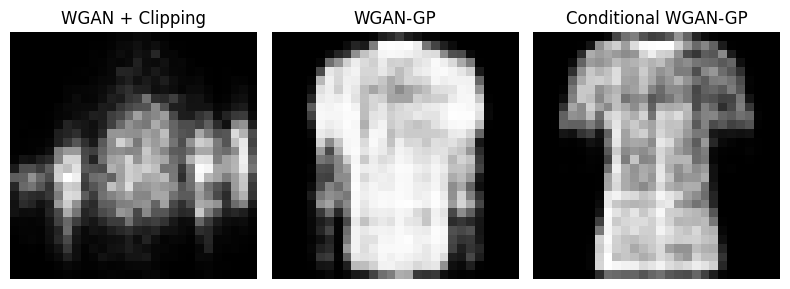

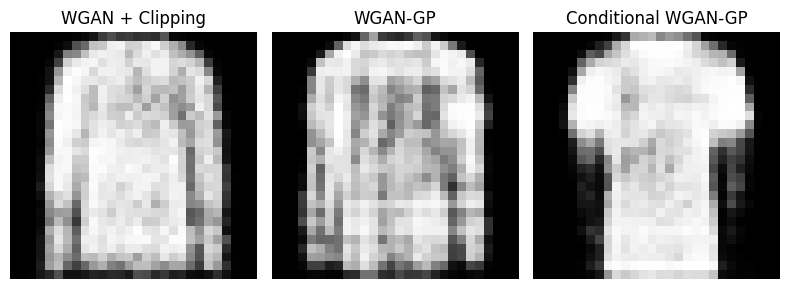

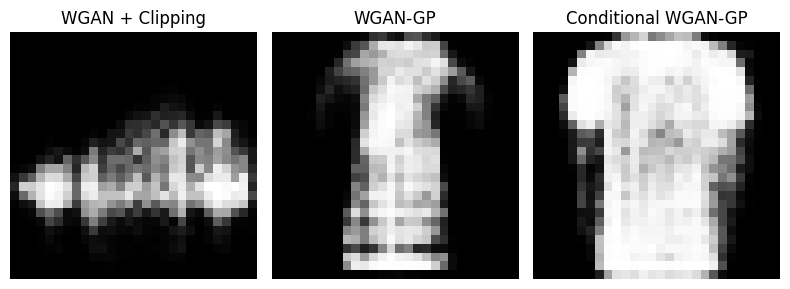

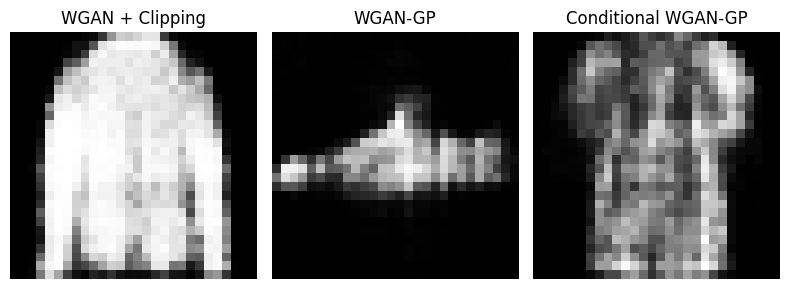

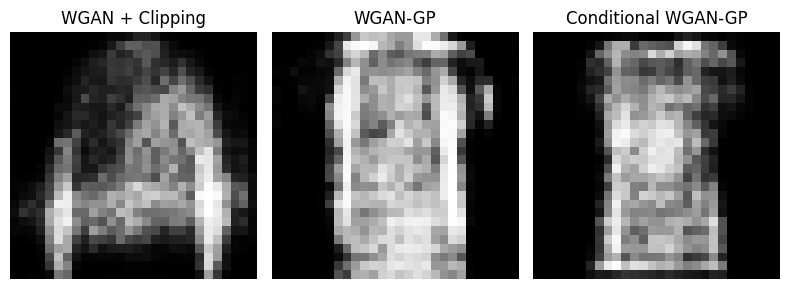

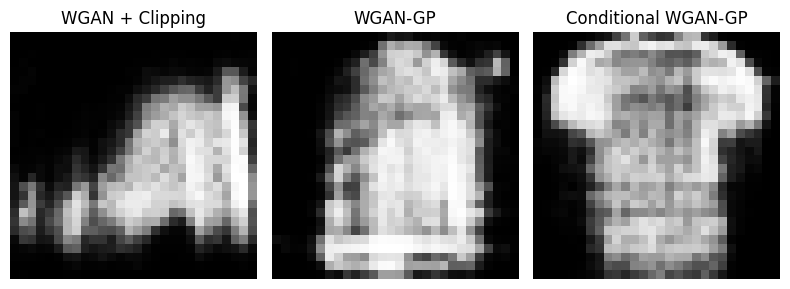

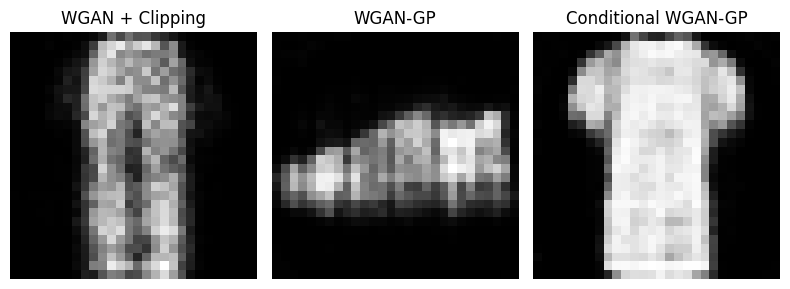

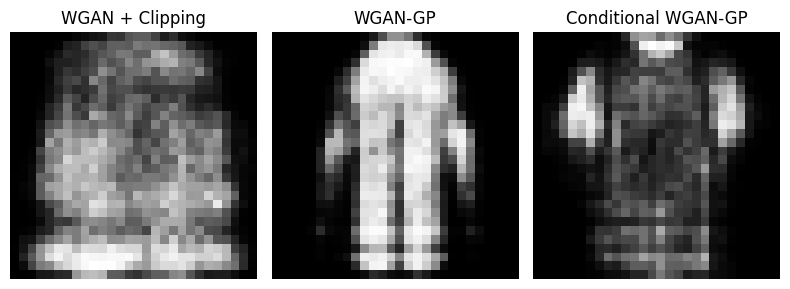

In [108]:
for _ in range(10):

    fig, axes = plt.subplots(1, 3, figsize=(8, 8))

    noise = torch.randn(16, config.noise_size)

    fake1 = gen_clip(noise)
    fake1 = (fake1 + 1) / 2
    fig1 = plt.figure(figsize=(4, 4))
    for i in range(16):
        ax = fig1.add_subplot(4, 4, i + 1)
        ax.imshow(fake1[i].detach().numpy().reshape(28, 28), cmap='gray')
        ax.axis('off')
    axes[0].imshow(fake1[0].detach().numpy().reshape(28, 28), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('WGAN + Clipping')
    plt.close(fig1)

    # WGAN-GP
    fake2 = gen_gp(noise)
    fake2 = (fake2 + 1) / 2
    fig2 = plt.figure(figsize=(4, 4))
    for i in range(16):
        ax = fig2.add_subplot(4, 4, i + 1)
        ax.imshow(fake2[i].detach().numpy().reshape(28, 28), cmap='gray')
        ax.axis('off')
    axes[1].imshow(fake2[0].detach().numpy().reshape(28, 28), cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('WGAN-GP')
    plt.close(fig2)

    labels = torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5])
    fake3 = gen_cond(noise, labels)
    fake3 = (fake3 + 1) / 2
    fig3 = plt.figure(figsize=(4, 4))
    for i in range(16):
        ax = fig3.add_subplot(4, 4, i + 1)
        ax.imshow(fake3[i].detach().numpy().reshape(28, 28), cmap='gray')
        ax.axis('off')
    axes[2].imshow(fake3[0].detach().numpy().reshape(28, 28), cmap='gray')
    axes[2].axis('off')
    axes[2].set_title('Conditional WGAN-GP')
    plt.close(fig3)

    plt.tight_layout()
    plt.show()


Выводы по работе:
1. Из-за нехватки ресурсов в колабе не удалось отследить разницу сети с большим количесвом слоев.
2. Пробовал обучать на 5ти эпохах и визуально виден худший результат генерации
3. Качество генерации улучшается с усложнением метода, возможно, стоит пообучать еще несколько эпох и качество генерации увеличится.
4. Почти все гипперпараметры брал из статей, с ними не экспериментировал
5. Видно по ошибке, что обучение более стабильное на conditional>wgan gp>wgan clipping

Можно улучшить:
1. поддержка GPU
2. После обучения модели сохранять веса, чтобы не пришлось обучать заново все при потери соединения
3. Усложнить архитектуру сеток